In [1]:
import tensorflow as tf
from tensorflow import keras
from loguru import logger
from tensorflow.keras.models import Model
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [2]:
# gpus = tf.config.list_logical_devices('GPU')
# mirrored_strategy = tf.distribute.MirroredStrategy(devices=gpus,cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

In [2]:

training_dir = "autoencoder/pics/denver1"
training_dir_uch = "autoencoder/pics/uchtdorf1"
image_size = (256, 256)


train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2
        # preprocessing_function=add_noise
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2
        # preprocessing_function=add_noise
        )

In [3]:
train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=128,
        class_mode='input',
        color_mode="grayscale",
        seed=42,shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=128,
        class_mode='input',
        color_mode="grayscale",
        subset="validation",
        seed=42)



train_generator_uch = train_datagen.flow_from_directory(
        training_dir_uch,
        target_size = image_size,
        subset="training",
        batch_size=128,
        class_mode='input',
        color_mode="grayscale",
        seed=42,shuffle=True)
validation_generator_uch = validation_datagen.flow_from_directory(
        training_dir_uch,
        target_size=image_size,
        batch_size=128,
        class_mode='input',
        color_mode="grayscale",
        subset="validation",
        seed=42)

Found 726 images belonging to 1 classes.
Found 181 images belonging to 1 classes.
Found 1463 images belonging to 1 classes.
Found 365 images belonging to 1 classes.


In [5]:
# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(
#         test_dir,
#         classes=['test'],
#         target_size=image_size,
#         class_mode='sparse',
#         shuffle=False)

In [6]:

# ourdata=tf.keras.preprocessing.image_dataset_from_directory(train,shuffle=True,
#                                                      batch_size=64,image_size=(256, 256),seed=123)
# uch=tf.keras.preprocessing.image_dataset_from_directory(train_uch,shuffle=True,
#                                                      batch_size=64,image_size=(256, 256),seed=123)
# def normalizer(generator):
#   normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

#   def change_inputs(images, labels):
#     x = tf.image.resize(normalization_layer(images),[256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
#     return x, x

#   return generator.map(change_inputs)
# normalized = normalizer(ourdata)
# normalized_uchtdorf = normalizer(uch)

In [7]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 256*256
        reconstruction_loss = tf.keras.backend.mean(tf.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

class Sampling(tf.keras.layers.Layer):
    """Uses (encoder_mu, encoder_log_variance) to sample encoder, the vector encoding a digit."""

    def call(self, inputs):
        encoder_mu, encoder_log_variance = inputs
        batch = tf.shape(encoder_mu)[0]
        dim = tf.shape(encoder_mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return encoder_mu + tf.exp(0.5 * encoder_log_variance) * epsilon



latent_space_dim=128
input_shape=(256,256,1)

'''encoder'''
encoder_input = tf.keras.layers.Input(shape=input_shape)
net = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1)(encoder_input)
net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2)(net)
net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", strides=4)(net)
net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1)(net)
net = tf.keras.layers.LeakyReLU()(net)
shape_before_flatten = K.int_shape(net)[1:]
net = tf.keras.layers.Flatten()(net)
encoder_mu = tf.keras.layers.Dense(units=latent_space_dim)(net)
encoder_log_variance = tf.keras.layers.Dense(units=latent_space_dim)(net)

# custom layer - will not run on DPU
encoder_z = Sampling()([encoder_mu, encoder_log_variance])

# encoder_mu,encoder_log_variance outputs go to loss function
# encoder_z is encoded latent space
encoder=Model(inputs=encoder_input, outputs=[encoder_mu,encoder_log_variance,encoder_z])


''' decoder '''
decoder_input = tf.keras.layers.Input(shape=latent_space_dim)
net = tf.keras.layers.Dense(units=np.prod(shape_before_flatten))(decoder_input)
net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Reshape(target_shape=shape_before_flatten)(net)
net = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), padding="same", strides=1)(net)
net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), padding="same", strides=4)(net)
net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), padding="same", strides=2)(net)
net = tf.keras.layers.LeakyReLU()(net)
decoder_output = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), padding="same", activation="sigmoid",strides=1)(net)


# standard sigmoid
#decoder_output = Activation('sigmoid')(net)

decoder = Model(inputs=decoder_input, outputs=decoder_output)

In [8]:

image_dim = 256
image_chan = 1
input_layer = tf.keras.layers.Input(shape=(image_dim,image_dim,image_chan))
encoder_mu, encoder_log_variance, encoder_z = encoder.call(input_layer)

dec_out = decoder.call(encoder_z)
model = Model(inputs=input_layer, outputs=dec_out)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 256, 256, 32  0           ['conv2d[1][0]']                 
                                )                                                           

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=loss_func(encoder_mu,encoder_log_variance),
              metrics=['mse'])

In [10]:
face = cv2.imread("autoencoder/pics/denver1/denver/denver_face1748.jpg")
face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
# plt.imshow(face)
# plt.show()
face = cv2.resize(face,(256,256))
face = np.reshape(face, (1,256,256,1))
face = face/255

In [11]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        
        uch_pred = encoder.predict(face)
        output = decoder.predict(uch_pred)
        output = np.reshape(output,(256,256))
        output = output*255
        plt.imshow(output)
        plt.savefig(f'created_img/img{epoch}.png',bbox_inches='tight',transparent=True, pad_inches=0)
        if epoch % 8 == 0:
            plt.imshow(output)
            plt.show()

2022-12-01 18:24:59.099191: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 18:25:12.970648: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38236 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0
2022-12-01 18:25:13.026696: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38236 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2022-12-01 18:25:13.028582: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/devi

Epoch 1/300


2022-12-01 18:25:16.533492: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-12-01 18:25:18.088595: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-01 18:25:19.122510: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


6/6 [==============================] - ETA: 0s - batch: 2.5000 - size: 121.0000 - loss: 3409.6971 - mse: 0.0516 

/projects/fpga_packet/mambaforge/envs/5g/lib/python3.9/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/projects/fpga_packet/mambaforge/envs/5g/lib/python3.9/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


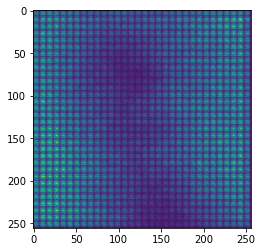

6/6 [==============================] - 16s 2s/step - batch: 2.5000 - size: 121.0000 - loss: 3419.2013 - mse: 0.0516 - val_loss: 2402.9135 - val_mse: 0.0351
Epoch 2/300
6/6 [==============================] - 3s 626ms/step - batch: 2.5000 - size: 121.0000 - loss: 2011.0315 - mse: 0.0292 - val_loss: 1581.4646 - val_mse: 0.0231
Epoch 3/300
6/6 [==============================] - 5s 984ms/step - batch: 2.5000 - size: 121.0000 - loss: 1591.6825 - mse: 0.0229 - val_loss: 1640.8688 - val_mse: 0.0236
Epoch 4/300
6/6 [==============================] - 5s 997ms/step - batch: 2.5000 - size: 121.0000 - loss: 1538.9292 - mse: 0.0221 - val_loss: 1524.8826 - val_mse: 0.0218
Epoch 5/300
6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 1528.0342 - mse: 0.0219 - val_loss: 1468.6832 - val_mse: 0.0211
Epoch 6/300
6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 1489.7056 - mse: 0.0213 - val_loss: 1520.5268 - val_mse: 0.0219


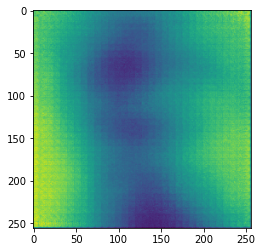

6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 1472.4961 - mse: 0.0211 - val_loss: 1449.6356 - val_mse: 0.0207
Epoch 10/300
6/6 [==============================] - 5s 928ms/step - batch: 2.5000 - size: 121.0000 - loss: 1447.5312 - mse: 0.0207 - val_loss: 1441.1265 - val_mse: 0.0208
Epoch 11/300
6/6 [==============================] - 5s 981ms/step - batch: 2.5000 - size: 121.0000 - loss: 1460.3428 - mse: 0.0209 - val_loss: 1469.3188 - val_mse: 0.0211
Epoch 12/300
6/6 [==============================] - 5s 984ms/step - batch: 2.5000 - size: 121.0000 - loss: 1499.6065 - mse: 0.0214 - val_loss: 1448.6544 - val_mse: 0.0208
Epoch 13/300
6/6 [==============================] - 5s 986ms/step - batch: 2.5000 - size: 121.0000 - loss: 1444.6214 - mse: 0.0206 - val_loss: 1452.9386 - val_mse: 0.0206
Epoch 14/300
6/6 [==============================] - 5s 991ms/step - batch: 2.5000 - size: 121.0000 - loss: 1431.8812 - mse: 0.0205 - val_loss: 1442.0939 - val_ms

In [ ]:

model.fit(
    x=train_generator,
    epochs=300,
    shuffle=True,
    validation_data = validation_generator,
    callbacks=[CustomCallback()]
)
model.save("bryan_ae.h5")

In [11]:
import cv2
import glob
import re
import os
img_array = []

for filename in sorted(glob.glob('created_img/*.png'),key=lambda x: int(re.findall("[0-9]+", x)[0])):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 30, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()


NameError: name 'size' is not defined

In [12]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 256*256
        reconstruction_loss = tf.keras.backend.mean(tf.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

class Sampling(tf.keras.layers.Layer):
    """Uses (encoder_mu, encoder_log_variance) to sample encoder, the vector encoding a digit."""

    def call(self, inputs):
        encoder_mu, encoder_log_variance = inputs
        batch = tf.shape(encoder_mu)[0]
        dim = tf.shape(encoder_mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return encoder_mu + tf.exp(0.5 * encoder_log_variance) * epsilon



latent_space_dim=128
input_shape2=(256,256,1)

'''encoder'''
encoder_input2 = tf.keras.layers.Input(shape=input_shape2)
net = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1)(encoder_input2)

net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2)(net)

net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", strides=4)(net)

net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", strides=1)(net)

net = tf.keras.layers.LeakyReLU()(net)
shape_before_flatten2 = K.int_shape(net)[1:]
net = tf.keras.layers.Flatten()(net)
encoder_mu2 = tf.keras.layers.Dense(units=latent_space_dim)(net)
encoder_log_variance2 = tf.keras.layers.Dense(units=latent_space_dim)(net)

# custom layer - will not run on DPU
encoder_z2 = Sampling()([encoder_mu2, encoder_log_variance2])

# encoder_mu,encoder_log_variance outputs go to loss function
# encoder_z is encoded latent space
encoder_uch=Model(inputs=encoder_input2, outputs=[encoder_mu2,encoder_log_variance2,encoder_z2])


''' decoder '''
decoder_input2 = tf.keras.layers.Input(shape=latent_space_dim)
net = tf.keras.layers.Dense(units=np.prod(shape_before_flatten2))(decoder_input2)
net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Reshape(target_shape=shape_before_flatten2)(net)
net = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), padding="same", strides=1)(net)

net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), padding="same", strides=4)(net)

net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), padding="same", strides=2)(net)

net = tf.keras.layers.LeakyReLU()(net)
decoder_output2 = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), padding="same",activation='sigmoid', strides=1)(net)

# standard sigmoid
#decoder_output = Activation('sigmoid')(net)

decoder_uch = Model(inputs=decoder_input2, outputs=decoder_output2)

In [13]:

image_dim = 256
image_chan = 1
input_layer = tf.keras.layers.Input(shape=(image_dim,image_dim,image_chan))
encoder_mu2, encoder_log_variance2, encoder_z2 = encoder_uch.call(input_layer)

dec_out = decoder_uch.call(encoder_z2)
model_uch = Model(inputs=input_layer, outputs=dec_out)
model_uch.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 256, 256, 32  320         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)      (None, 256, 256, 32  0           ['conv2d_4[1][0]']               
                                )                                                           

In [14]:
model_uch.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=loss_func(encoder_mu2,encoder_log_variance2),
              metrics=['mse'])

In [15]:
face = cv2.imread('autoencoder/pics/uchtdorf1/uchtdorf/uchtdorf_face1860.jpg")
face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
# plt.imshow(face)
# plt.show()
face = cv2.resize(face,(256,256))
face = np.reshape(face, (1,256,256,1))
face = face/255

In [16]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        uch_pred = encoder_uch.predict(face)
        output = decoder_uch.predict(uch_pred)
        output = np.reshape(output,(256,256))
        output = output*255
        plt.imshow(output)
        plt.savefig(f'created_img2/img{epoch}.png',bbox_inches='tight',transparent=True, pad_inches=0)
        if epoch % 8 == 0:
            plt.imshow(output)
            plt.show()

Epoch 1/300
12/12 [==============================] - ETA: 0s - batch: 5.5000 - size: 121.9167 - loss: 3970.4227 - mse: 0.0615

/projects/fpga_packet/mambaforge/envs/5g/lib/python3.9/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/projects/fpga_packet/mambaforge/envs/5g/lib/python3.9/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


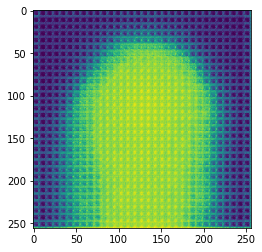

12/12 [==============================] - 20s 2s/step - batch: 5.5000 - size: 121.9167 - loss: 3976.2252 - mse: 0.0615 - val_loss: 2205.5861 - val_mse: 0.0334
Epoch 2/300
12/12 [==============================] - 6s 550ms/step - batch: 5.5000 - size: 121.9167 - loss: 1820.8428 - mse: 0.0276 - val_loss: 1553.5156 - val_mse: 0.0234
Epoch 3/300
12/12 [==============================] - 10s 921ms/step - batch: 5.5000 - size: 121.9167 - loss: 1306.7844 - mse: 0.0197 - val_loss: 1171.7825 - val_mse: 0.0177
Epoch 4/300
12/12 [==============================] - 10s 920ms/step - batch: 5.5000 - size: 121.9167 - loss: 1109.5832 - mse: 0.0167 - val_loss: 1050.2968 - val_mse: 0.0158
Epoch 5/300
12/12 [==============================] - 10s 894ms/step - batch: 5.5000 - size: 121.9167 - loss: 979.3595 - mse: 0.0148 - val_loss: 917.6367 - val_mse: 0.0137
Epoch 6/300
12/12 [==============================] - 11s 951ms/step - batch: 5.5000 - size: 121.9167 - loss: 879.5227 - mse: 0.0131 - val_loss: 854.7296 

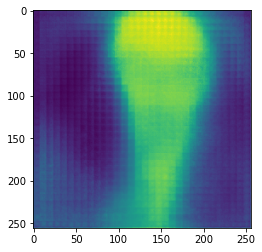

12/12 [==============================] - 11s 934ms/step - batch: 5.5000 - size: 121.9167 - loss: 655.3073 - mse: 0.0098 - val_loss: 635.9621 - val_mse: 0.0095
Epoch 10/300
12/12 [==============================] - 10s 913ms/step - batch: 5.5000 - size: 121.9167 - loss: 600.2157 - mse: 0.0089 - val_loss: 572.2282 - val_mse: 0.0085
Epoch 11/300
12/12 [==============================] - 10s 898ms/step - batch: 5.5000 - size: 121.9167 - loss: 580.9820 - mse: 0.0086 - val_loss: 576.1795 - val_mse: 0.0085
Epoch 12/300
12/12 [==============================] - 10s 918ms/step - batch: 5.5000 - size: 121.9167 - loss: 553.9692 - mse: 0.0082 - val_loss: 537.3415 - val_mse: 0.0080
Epoch 13/300
12/12 [==============================] - 10s 905ms/step - batch: 5.5000 - size: 121.9167 - loss: 535.2181 - mse: 0.0079 - val_loss: 525.0313 - val_mse: 0.0078
Epoch 14/300
12/12 [==============================] - 10s 926ms/step - batch: 5.5000 - size: 121.9167 - loss: 512.4564 - mse: 0.0076 - val_loss: 509.3186

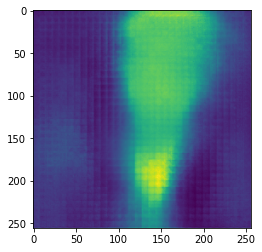

12/12 [==============================] - 11s 943ms/step - batch: 5.5000 - size: 121.9167 - loss: 458.9545 - mse: 0.0068 - val_loss: 428.7185 - val_mse: 0.0063
Epoch 18/300
12/12 [==============================] - 10s 895ms/step - batch: 5.5000 - size: 121.9167 - loss: 442.7991 - mse: 0.0065 - val_loss: 431.1618 - val_mse: 0.0063
Epoch 19/300
12/12 [==============================] - 10s 908ms/step - batch: 5.5000 - size: 121.9167 - loss: 428.6706 - mse: 0.0063 - val_loss: 424.4377 - val_mse: 0.0062
Epoch 20/300
12/12 [==============================] - 10s 912ms/step - batch: 5.5000 - size: 121.9167 - loss: 426.4778 - mse: 0.0063 - val_loss: 419.5093 - val_mse: 0.0062
Epoch 21/300
12/12 [==============================] - 10s 919ms/step - batch: 5.5000 - size: 121.9167 - loss: 416.4142 - mse: 0.0061 - val_loss: 407.2961 - val_mse: 0.0060
Epoch 22/300
12/12 [==============================] - 10s 910ms/step - batch: 5.5000 - size: 121.9167 - loss: 407.4046 - mse: 0.0060 - val_loss: 413.9040

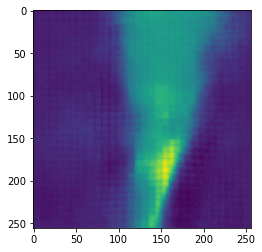

12/12 [==============================] - 10s 924ms/step - batch: 5.5000 - size: 121.9167 - loss: 378.7735 - mse: 0.0056 - val_loss: 386.7654 - val_mse: 0.0057
Epoch 26/300
12/12 [==============================] - 10s 874ms/step - batch: 5.5000 - size: 121.9167 - loss: 363.9572 - mse: 0.0053 - val_loss: 367.3495 - val_mse: 0.0054
Epoch 27/300
12/12 [==============================] - 11s 966ms/step - batch: 5.5000 - size: 121.9167 - loss: 367.0896 - mse: 0.0054 - val_loss: 359.8536 - val_mse: 0.0052
Epoch 28/300
12/12 [==============================] - 10s 935ms/step - batch: 5.5000 - size: 121.9167 - loss: 341.4838 - mse: 0.0049 - val_loss: 343.1082 - val_mse: 0.0050
Epoch 29/300
12/12 [==============================] - 10s 935ms/step - batch: 5.5000 - size: 121.9167 - loss: 341.5448 - mse: 0.0050 - val_loss: 334.9199 - val_mse: 0.0049
Epoch 30/300
12/12 [==============================] - 10s 915ms/step - batch: 5.5000 - size: 121.9167 - loss: 334.9500 - mse: 0.0049 - val_loss: 335.8771

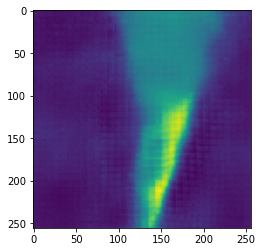

12/12 [==============================] - 11s 955ms/step - batch: 5.5000 - size: 121.9167 - loss: 334.7270 - mse: 0.0049 - val_loss: 321.0289 - val_mse: 0.0047
Epoch 34/300
12/12 [==============================] - 10s 897ms/step - batch: 5.5000 - size: 121.9167 - loss: 320.9232 - mse: 0.0047 - val_loss: 323.2399 - val_mse: 0.0047
Epoch 35/300
12/12 [==============================] - 10s 906ms/step - batch: 5.5000 - size: 121.9167 - loss: 313.5273 - mse: 0.0045 - val_loss: 305.2377 - val_mse: 0.0044
Epoch 36/300
12/12 [==============================] - 10s 903ms/step - batch: 5.5000 - size: 121.9167 - loss: 310.9025 - mse: 0.0045 - val_loss: 300.4405 - val_mse: 0.0043
Epoch 37/300
12/12 [==============================] - 10s 906ms/step - batch: 5.5000 - size: 121.9167 - loss: 298.9793 - mse: 0.0043 - val_loss: 293.2437 - val_mse: 0.0042
Epoch 38/300
12/12 [==============================] - 10s 913ms/step - batch: 5.5000 - size: 121.9167 - loss: 291.7317 - mse: 0.0042 - val_loss: 294.4767

In [ ]:
model_uch.fit(
    x=train_generator_uch,
    epochs=300,
    shuffle=True,
    validation_data = validation_generator_uch,
    callbacks=[CustomCallback()]
)
model_uch.save("uch_ae.h5")

In [ ]:
import cv2
import glob
import re
import os
img_array = []

for filename in sorted(glob.glob('created_img2/*.png'),key=lambda x: int(re.findall("[0-9]+", x)[0])):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 30, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()


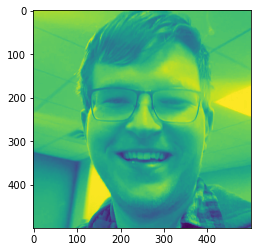

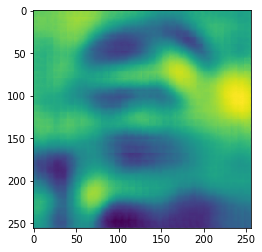

True

In [43]:
face = cv2.imread("autoencoder/pics/denver1/denver/denver_face1748.jpg")
face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
plt.imshow(face)
plt.show()
face = cv2.resize(face,(256,256))
face = np.reshape(face, (1,256,256,1))
face = face/255
uch_pred = encoder.predict(face)
output = decoder.predict(uch_pred)
output = np.reshape(output,(256,256))
output = output*255
plt.imshow(output)
plt.show()
cv2.imwrite("autoencoder/bryan2bryan.png", output)

In [17]:
face = cv2.imread("autoencoder/pics/uchtdorf1/uchtdorf/uchtdorf_face1860.jpg")
face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
face = cv2.resize(face,(256,256))
face = np.reshape(face, (1,256,256,1))
face = face/255
uch_pred = encoder_uch.predict(face)
output = decoder.predict(uch_pred)
output = np.reshape(output,(256,256))
output = output*255
plt.imshow(output)
plt.show()
cv2.imwrite("autoencoder/uch2bryan.png", output)

/projects/fpga_packet/mambaforge/envs/5g/lib/python3.9/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


True

In [18]:
face = cv2.imread("autoencoder/pics/uchtdorf1/uchtdorf/uchtdorf_face1860.jpg")
face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
face = plt.imshow(face)
plt.show()
face = cv2.resize(face,(256,256))
# face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
face = np.reshape(face, (1,256,256,1))
face = face/255
uch_pred = encoder.predict(face)
output = decoder_uch.predict(uch_pred)
output = np.reshape(output,(256,256))
output = output*255
output = plt.imshow(output)
plt.show()
print(output)
cv2.imwrite("autoencoder/bryan2uch.png", output)

/projects/fpga_packet/mambaforge/envs/5g/lib/python3.9/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[[73.158646 71.86848  75.54901  ... 70.44346  67.81974  78.289825]
 [72.194916 59.513496 65.72693  ... 68.88412  60.87049  64.83062 ]
 [72.773575 72.18363  72.702774 ... 69.25699  67.9479   70.96266 ]
 ...
 [81.69774  76.990875 82.0752   ... 70.40954  71.64061  72.11833 ]
 [82.80631  79.38874  80.014084 ... 73.518486 72.036514 74.37137 ]
 [90.321365 79.19084  82.99035  ... 76.29884  73.7122   82.407234]]


True

In [19]:
face = cv2.imread("autoencoder/pics/uchtdorf1/uchtdorf/uchtdorf_face1860.jpg")
face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
face = cv2.resize(face,(256,256))
# face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
face = np.reshape(face, (1,256,256,1))
face = face/255
uch_pred = encoder_uch.predict(face)
output = decoder_uch.predict(uch_pred)
output = np.reshape(output,(256,256))
output = output*255
print(output)
cv2.imwrite("autoencoder/uch2uch.png", output)

[[10.202295  14.393406  14.998775  ... 13.9431715 13.435194  27.458897 ]
 [ 9.94217   13.233146  11.239101  ... 11.753511  14.3036585 13.810681 ]
 [11.970908  11.211279  12.538871  ... 14.456444  13.488461  19.487148 ]
 ...
 [56.583935  52.86548   60.51638   ... 62.66951   61.07084   64.36089  ]
 [58.870716  56.28285   55.960007  ... 62.749676  62.079266  65.62032  ]
 [74.44507   61.669598  63.37912   ... 66.496956  69.48049   73.47808  ]]


True